# Fake news detection using LSTM model and Word2Vec

In [36]:
# Other
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import re
import gensim

#Sklearn
import sklearn
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Bidirectional
from keras.callbacks import EarlyStopping
tf.keras.backend.clear_session()

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Erik
[nltk_data]     Konstenius\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
fake = pd.read_csv(r"C:\Users\Erik Konstenius\Downloads\Fake.csv")
true = pd.read_csv(r"C:\Users\Erik Konstenius\Downloads\True.csv")

In [6]:
print("Example of fake tweet:")
print(fake["title"][4])
print(fake["title"][65])
print(fake["title"][200])

Example of fake tweet:
 Pope Francis Just Called Out Donald Trump During His Christmas Speech
 Principles Over Power: Why Republicans Need To Do What’s Right To Remain Relevant
 Bill Maher Takes Down Trump’s Lying Chief Of Staff In BLISTERING Rebuke (VIDEO)


In [7]:
print("Example of true tweet")
print(true["title"][4])
print(true["title"][65])
print(true["title"][200])

Example of true tweet
Trump wants Postal Service to charge 'much more' for Amazon shipments
Senator Cornyn trying to get Big Corn behind U.S. biofuels reform
U.S. Congress to let Iran deadline pass, leave decision to Trump


In [8]:
fake['Fake news?']=0
true['Fake news?']=1
df = true.append(fake).reset_index(drop=True)

In [9]:
df.head()

,title,text,subject,date,Fake news?
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
df.tail()

,title,text,subject,date,Fake news?
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [11]:
df.dtypes

title         object
text          object
subject       object
date          object
Fake news?     int64
dtype: object

In [12]:
df.isna().sum()

title         0
text          0
subject       0
date          0
Fake news?    0
dtype: int64

In [13]:
# convert text to lower case
df['text'] = df['text'].str.lower()

In [14]:
# remove stop words
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [15]:
# Let's look at some sentences
print(df['text'][0][0:250])

washington (reuters) - head conservative republican faction u.s. congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” sunday urged budget restraint 2018. keeping sharp pivot way among republicans, u.s. represe


In [16]:
texts = []
for text in df['text']:
    temp = re.sub('[^A-Za-z0-9-" "]+', '', text) #remove special characters
    texts.append(re.sub(r'\b\w{1,2}\b', '', temp)) #remove short words

output = [word_tokenize(sentence) for sentence in texts]

df["text"] = output

In [17]:
# Let's look at some sentences
print(df['text'][0][0:100])

['washington', 'reuters', '-', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', '2018', 'keeping', 'sharp', 'pivot', 'way', 'among', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'cbs', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'even', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'keep', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'big', 'budget', 'increase', 'military', 'spending', 'democrats', 'also', 'want', 'proportional', 'increases', 'non-defense', 'discretionary', 'spending', 'programs', 'supp

In [18]:
word2vec = gensim.models.Word2Vec(sentences = df['text'], size = 100, window =5, min_count=1)

In [19]:
len(word2vec.wv.vocab) 

226926

In [20]:
word2vec.wv.most_similar("president")

[('president-elect', 0.7009356021881104),
 ('presidents', 0.6963850259780884),
 ('presidency', 0.5985151529312134),
 ('versa', 0.5543861389160156),
 ('successor', 0.538605809211731),
 ('presidentbiden', 0.5332692861557007),
 ('succeed', 0.5212979912757874),
 ('matefeatured', 0.5066452026367188),
 ('l4n1n304g', 0.5008398294448853),
 ('presidential', 0.4977143704891205)]

In [21]:
# Tokenize text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) #returns ID for the top 1000 words
tokenizer.fit_on_texts(df['text'])

In [22]:
df.head()

,title,text,subject,date,Fake news?
0,"As U.S. budget fight looms, Republicans flip t...","[washington, reuters, -, head, conservative, r...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,"[washington, reuters, -, transgender, people, ...",politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[washington, reuters, -, special, counsel, inv...",politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,"[washington, reuters, -, trump, campaign, advi...",politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,"[seattlewashington, reuters, -, president, don...",politicsNews,"December 29, 2017",1


In [23]:
# Convert words to numbers
df['text'] = tokenizer.texts_to_sequences(df['text'])

In [24]:
df.head() # The text is now tokenized

,title,text,subject,date,Fake news?
0,"As U.S. budget fight looms, Republicans flip t...","[33, 11, 6, 311, 202, 18, 99, 648, 165, 44, 85...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,"[33, 11, 6, 5, 585, 31, 28, 83, 115, 80, 1, 11...",politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,"[33, 11, 6, 373, 163, 67, 4, 75, 120, 29, 24, ...",politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,"[33, 11, 6, 2, 24, 716, 590, 21, 41, 120, 67, ...",politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,"[11, 6, 4, 12, 2, 82, 440, 111, 98, 733, 102, ...",politicsNews,"December 29, 2017",1


In [25]:
# The text documents have different length
print(len(df["text"][0]))
print(len(df["text"][2]))

293
183


In [26]:
# To be able to run the model, the length of all vectors must be the same. I therefore documents to 
# the same length. This will be done in the following way.
# All texts are converted to the length of the 99 th percentile - I.e 845 words. 
# Texts longer than the length of the 99 th percentile get truncated. 
# Texts shorter than the length of the 99 th percentile get padded with 0s
# This method also removes outliers in terms of text length.

documents = []
for i in df["text"]:
    documents.append(i)

max_length = int(np.percentile([len(x) for x in documents],99))
word_index = tokenizer.word_index #enables conversion back to words

In [27]:
documents = sequence.pad_sequences(documents, maxlen=max_length,padding='post')
word_index = tokenizer.word_index #enables conversion back to words

In [28]:
weight_matrix = np.zeros((len(tokenizer.word_index)+1, 100))
for word, i in word_index.items():
    weight_matrix[i] = word2vec[word]

<ipython-input-28-63758b98cfe5>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  weight_matrix[i] = word2vec[word]


In [29]:
print("Number of words: " + str(len(weight_matrix))) 
print("Number of vectors for each word: " + str(len(weight_matrix[0])))

Number of words: 226927
Number of vectors for each word: 100


## Creating the LSTM model

We will begin by creating an embedding layer so that we can capture similarities between words using our glove method.

The construction of the model is partially determined by the achieved accuracy but also by the high risk of the vanishing and exploding gradient problem. More layers would capture more complex relations but it would also risk causing the exploding gradient problem

In [144]:
model = Sequential()
model.add(Embedding((len(word_index)+1), output_dim = 100, weights=[weight_matrix], trainable=False, input_length=max_length))
model.add(Bidirectional(LSTM(units=64,return_sequences=True, dropout = 0.35)))
model.add(Bidirectional(LSTM(units=32, dropout = 0.35)))
model.add(Dense(1, activation='sigmoid'))

# Training the model

In [115]:
X_train, X_test, y_train, y_test = train_test_split(documents, df["Fake news?"], test_size=0.2, random_state=42)

In [116]:
# needs to be array for tensorflow's tensor conversion

X_train = np.asarray(X_train).astype('int64')
X_test = np.asarray(X_test).astype('int64')
y_train = np.asarray(y_train).astype('int64').reshape((-1,1))
y_test = np.asarray(y_test).astype('int64').reshape((-1,1))

In [33]:
# Check that the conversion works as expected
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

35918
8980
35918
8980


In [145]:
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate = 0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 428, 100)          22692700  
                                                                 
 bidirectional_8 (Bidirectio  (None, 428, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,818,461
Trainable params: 125,761
Non-trainable params: 22,692,700
_________________________________________________________________


In [146]:
model.fit(X_train, y_train, epochs=2, validation_split = 0.2, batch_size=64)
model.save("LSTM_model")

Epoch 1/2
449/449 [==============================] - 194s 425ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.0096 - val_accuracy: 0.9972
Epoch 2/2
449/449 [==============================] - 220s 489ms/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.0088 - val_accuracy: 0.9971


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


# Evaluating the model

#### Accuracy, precision, recall, f1-score

In [147]:
model = keras.models.load_model('LSTM_model')

y_pred = (model.predict(X_test) > 0.5).astype("int64")

In [148]:
accuracy_score(y_test, y_pred)

0.9961024498886414

In [149]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4650
           1       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



#### Precision-Recall Curve

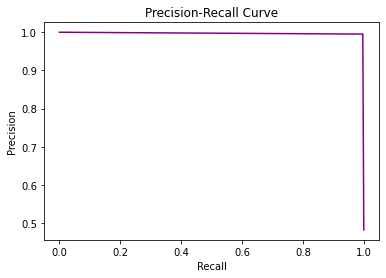

In [152]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

#### ROC Plot

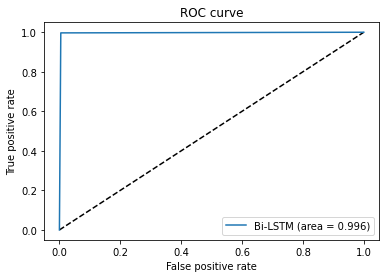

In [159]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Bi-LSTM (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Conclusion

The model provided very good results on both the training data and the testing data. 